# MNIST

Lisää informaatio datasta ja kilpailusta:
https://www.kaggle.com/c/digit-recognizer/data

## Datan lataus ja tarkastelu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn import model_selection
%matplotlib inline

In [2]:
#Luetaan data
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

Katsotaan miltä data näyttää

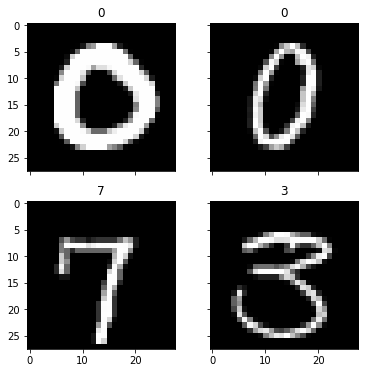

In [3]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, sharex=True, sharey=True, figsize=(6,6))

ax1.imshow(df_train.loc[4,df_train.columns[1]:df_train.columns[-1]].to_numpy().reshape((28,28)), cmap='gray')
ax2.imshow(df_train.loc[5,df_train.columns[1]:df_train.columns[-1]].to_numpy().reshape((28,28)), cmap='gray')
ax3.imshow(df_train.loc[6,df_train.columns[1]:df_train.columns[-1]].to_numpy().reshape((28,28)), cmap='gray')
ax4.imshow(df_train.loc[7,df_train.columns[1]:df_train.columns[-1]].to_numpy().reshape((28,28)), cmap='gray')
#fig.tight_layout()
ax1.set(title=df_train.loc[4,df_train.columns[0]])
ax2.set(title=df_train.loc[5,df_train.columns[0]])
ax3.set(title=df_train.loc[6,df_train.columns[0]])
ax4.set(title=df_train.loc[7,df_train.columns[0]])
plt.show()

In [4]:
print(f"Koulutus setissä: {df_train.shape[0]} kuvaa")
print(f"Testi setissä: {df_test.shape[0]} kuvaa")

Koulutus setissä: 42000 kuvaa
Testi setissä: 28000 kuvaa


<AxesSubplot:>

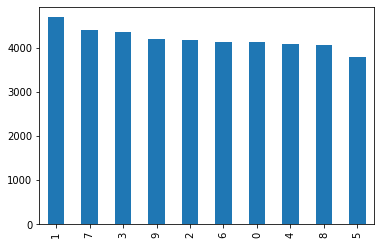

In [5]:
df_train['label'].value_counts().plot(kind='bar') 

Train-data näyttäisi olevan tasapainossa.

## Data augmentaatio
Augmentaatiossa luodaan lisää dataa muokkaamalla olemassa olevia kuvia. Augmentaatio toimii regularisaatio metodina ja vähentää ylisovituksen riskin määrää.
Tässä tapauksessa kuviin lisätään satunnaisesti eri määriä kohinaa ja kiertoa.

### Rotaatio
Kutakin kuvan pikseliä $(x,y)$ voidaan kuvata paikkavektorilla. Uudet paikat $\theta$ suuruisen rotaation jälkeen ovat

$x' = x cos(\theta) - y sin(\theta)$ 

$y' = x sin(\theta) + y cos(\theta)$

Esimerkki

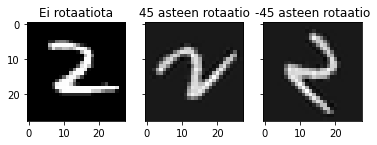

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,sharey=True)
ax1.imshow(df_train.loc[56,df_train.columns[1]:df_train.columns[-1]].to_numpy().reshape((28,28)), cmap='gray')
picture = df_train.loc[56,df_train.columns[1]:df_train.columns[-1]].to_numpy().reshape((28,28))
picture2 = ndimage.rotate(picture, -45, reshape=False)
picture = ndimage.rotate(picture, 45, reshape=False)
ax2.imshow(picture, cmap='gray')
ax3.imshow(picture2, cmap='gray')
ax1.set(title='Ei rotaatiota')
ax2.set(title='45 asteen rotaatio')
ax3.set(title='-45 asteen rotaatio')
plt.show()

In [7]:
def random_rotation(image):
    theta = np.random.randint(-45, 45) #random angle
    rotated_image = ndimage.rotate(image, theta, reshape=False)
    return rotated_image

def pick_random_image(dataframe):
    random_row = np.random.randint(0, dataframe.shape[0])
    random_image = df_train.loc[random_row,df_train.columns[1]:df_train.columns[-1]].to_numpy().reshape((28,28))
    return random_image

Augmentoidaan 400 kuvaa per numero. (n. 10% lisää dataa)

In [8]:
def augment(dataframe, label):
    rows_list=[]
    sample_data = dataframe[dataframe['label']==label]
    for i in range(0,400):
        rotated_image = random_rotation(pick_random_image(sample_data))
        row = np.append(label, rotated_image.flatten())
        rows_list.append(row)

    return pd.DataFrame(rows_list, columns=dataframe.columns)

matrix_train = df_train.to_numpy()
print(f"Ennen augmentointia: {matrix_train.shape}")
for i in range(0,10):
    aug = augment(df_train.sample(frac=0.1), i)
    tmp_matrix = np.vstack([matrix_train, aug])
    matrix_train = tmp_matrix
    
print(f"Augmentoinnin jälkeen: {matrix_train.shape}")

Ennen augmentointia: (42000, 785)
Augmentoinnin jälkeen: (46000, 785)


Tarkistetaan vielä, että jakauma on pysynyt hyvänä

<AxesSubplot:>

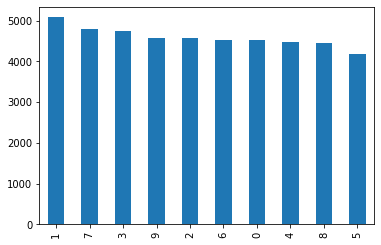

In [9]:
pd.DataFrame(matrix_train)[0].value_counts().plot(kind='bar') 

### Datan skaalaus


Kaikki pikseli arvot on nyt välillä $0-255$, mutta skaalataan ne välille $[0..1]$. Skaalaus helpottaa optimisointi algoritmia löytämään globaalin minimin.
Skaalaus tapahtuu jakamalla kaikki arvot $255$.

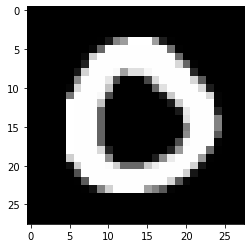

In [10]:
df_train_augmented = pd.DataFrame(matrix_train)
df_train_augmented_norm = df_train_augmented.iloc[:, 1:] / 255
plt.imshow(df_train_augmented_norm.loc[4,1:784].to_numpy().reshape((28,28)), cmap='gray')

### Train test split
Jaetaan data kahteen osaan suhteessa 90/10, jossa 90% datasta käytetään mallin kouluttamiseen ja 10 % käytetään mallin arviointiin. Tämä siksi, koska annetussa testi datassa ei ole annettu oikeaa vastausta.

In [11]:
X = df_train_augmented_norm.loc[:, 1:784]
y = df_train_augmented.iloc[:, 0]

In [12]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.1, random_state=42) 
#Set random state for pseudorandomness

In [13]:
print(f"X_train shape: {X_train.shape}; y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}; y_test shape: {y_test.shape}")

X_train shape: (41400, 784); y_train shape: (41400,)
X_test shape: (4600, 784); y_test shape: (4600,)


## Mallin luominen
### CNN - Convolutional neural networks

In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [15]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        #1. konvoluutio
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size = 6, stride = 1, padding = 0)
        self.relu1 = nn.ReLU()
        #22x22x16
        
        #1. Max pooling
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #11x11x16
        
        
        #2. konvoluutio
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels= 32, kernel_size = 3, stride=1, padding =0)
        self.relu2 = nn.ReLU()
        #9x9x32
        
        # 2. maxpooling
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        #4x4x32
        
        #FC
        self.fc1 = nn.Linear(32*4*4,10)
        
    def forward(self, x):
        out = self.cnn1(x)
        out=self.relu1(out)  #1.konv
        out = self.maxpool1(out)  #1.max
        out= self.cnn2(out)
        out=self.relu2(out) #2.conv
        out=self.maxpool2(out)#2.max
        out = out.view(out.size(0), -1) #flatten for fc
        out = self.fc1(out) #linear out
        return out
    
model = CNNModel()

In [41]:
import torch.optim as optim

features_train = torch.from_numpy(X_train.to_numpy().astype(np.float32))
label_train = torch.from_numpy(y_train.to_numpy().astype(np.float32)).type(torch.LongTensor)
features_test = torch.from_numpy(X_test.to_numpy().astype(np.float32))
label_test = torch.from_numpy(y_test.to_numpy().astype(np.float32)).type(torch.LongTensor)
train = torch.utils.data.TensorDataset(features_train, label_train)
test = torch.utils.data.TensorDataset(features_test, label_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = 100, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 100, shuffle = True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [42]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(8):
    for i, (images,labels) in enumerate(train_loader):
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        count += 1
        
        if count % 50 == 0:
            correct = 0
            total = 0
            for images, labels in test_loader:
                test = Variable(images.view(100,1,28,28))
                
                outputs = model(test)
                
                predicted = torch.max(outputs.data, 1)[1]
                
                total += len(labels)
                correct += (predicted == labels).sum()
                
            accuracy = 100 * correct / float(total)
            
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 250 == 0:
            print(f"Iteration: {count} \n Loss: {loss.data} \n Accuracy: {accuracy}.")

Iteration: 250 
 Loss: 0.45241475105285645 
 Accuracy: 90.63043212890625.
Iteration: 500 
 Loss: 0.6133931279182434 
 Accuracy: 90.65217590332031.
Iteration: 750 
 Loss: 0.5700414776802063 
 Accuracy: 90.4565200805664.
Iteration: 1000 
 Loss: 0.26190468668937683 
 Accuracy: 90.67391204833984.
Iteration: 1250 
 Loss: 0.5478730797767639 
 Accuracy: 90.67391204833984.
Iteration: 1500 
 Loss: 0.6204952001571655 
 Accuracy: 90.76087188720703.
Iteration: 1750 
 Loss: 0.3303655982017517 
 Accuracy: 90.63043212890625.
Iteration: 2000 
 Loss: 0.2510245740413666 
 Accuracy: 90.5434799194336.
Iteration: 2250 
 Loss: 0.40671417117118835 
 Accuracy: 90.67391204833984.
Iteration: 2500 
 Loss: 0.36767876148223877 
 Accuracy: 90.5.
Iteration: 2750 
 Loss: 0.35545843839645386 
 Accuracy: 90.47826385498047.
Iteration: 3000 
 Loss: 0.2771175503730774 
 Accuracy: 90.21739196777344.
Iteration: 3250 
 Loss: 0.5785958170890808 
 Accuracy: 90.60869598388672.


## Evaluaatio

In [43]:
torch.save(model, './mnist_model.pt')
validate = df_test.to_numpy().astype(np.float32) / 255
validate_features = torch.from_numpy(validate)

In [77]:
val_loader = torch.utils.data.DataLoader(validate_features, batch_size = 100)
outputs = np.array([])
with torch.no_grad():
    for i, data in enumerate(val_loader):
        data = Variable(data.view(100,1,28,28))
        output = model(data)
        predicted = torch.max(output.data, 1)[1]
        #outputs.append(predicted.numpy())
        outputs = np.append(outputs, predicted.numpy())
    

In [84]:
df_val = pd.DataFrame(outputs.flatten().astype(int))
df_val.index += 1

In [85]:
df_val.to_csv('./submission.csv', index=True)

https://www.kaggle.com/jaka0206

Tämä malli saavutti kilpailussa n. $98 \%$ tarkkuuden.